In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
import keras


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.6.2


In [ ]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

In [ ]:
train_data, train_labels = next(train_data_gen)
train_data.shape, train_labels.shape

In [ ]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
alexnet = tf.keras.models.load_model("../input/pretrainedmodels/AlexNet")
alexnetres = alexnet.predict(train_data)

In [ ]:
del alexnet
alexnet.shape

In [ ]:
densenet = tf.keras.models.load_model("../input/pretrainedmodels/DenseNet121")
densenetres = densenet.predict(train_data)

In [ ]:
del densenet
densenetres.shape

In [ ]:
inception = tf.keras.models.load_model("../input/pretrainedmodels/InceptionV3")
inceptionres = inception.predict(train_data)

In [ ]:
del inception
inceptionres.shape

In [ ]:
train_data_max = np.concatenate((alexnetres, densenetres, inceptionres), axis = 1)
train_data_max.shape

In [ ]:
train_labels_max = np.argmax(train_labels, 1)

In [ ]:
ensemble_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(None, 12)),
    keras.layers.Dense(4, activation = "softmax")
])

In [ ]:
ensemble_model.summary()

In [ ]:
ensemble_model.compile(optimizer='adam', 
              loss=tf.losses.CategoricalCrossentropy(from_logits=True))

In [ ]:
history = ensemble_model.fit(
    x=train_data_max,
    y=train_labels,
    epochs=50
)

In [ ]:
! pwd

In [ ]:
ensemble_model.save("EnsembleNetNew", save_format = 'h5')

In [11]:
ensemble = tf.keras.models.load_model("../input/traintestdatafiles/EnsembleNet")
ensemble.get_weights()

[array([[ 1.64236  , -1.5507684, -1.8844889, -1.0859991],
        [-2.188449 ,  2.5555985, -2.3778446, -2.5428169],
        [-1.8021193, -2.6569774,  1.3071264, -0.5805535],
        [-1.6198841, -1.9852972, -0.5325705,  0.924758 ],
        [ 1.4683993, -1.4049757, -1.0902952, -2.0857735],
        [-2.4883807,  2.823839 , -1.4066558, -2.3264072],
        [-1.2729852, -2.6658113,  2.4710364, -1.8697505],
        [-2.438154 , -2.2407992, -1.7366282,  1.6731118],
        [ 1.4619582, -1.1369219, -1.1578711, -1.5726988],
        [-2.5713775,  2.7656653, -1.9324615, -3.1422467],
        [-1.9355172, -2.204217 ,  1.726023 , -1.1297315],
        [-1.2404293, -1.6782519, -0.9646735,  1.107505 ]], dtype=float32),
 array([ 0.47545877, -1.1497468 , -0.34274375,  0.5825206 ], dtype=float32)]

In [12]:
x_test = np.load("../input/traintestdatafiles/test_data.npy")
y_test = np.load("../input/traintestdatafiles/test_labels.npy")

## <b><u>PRINTING CONFUSION MATRIX:</u></b>

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
data = x_test
alexnet = tf.keras.models.load_model("../input/pretrainedmodels/AlexNet")
densenet = tf.keras.models.load_model("../input/pretrainedmodels/DenseNet121")
inception = tf.keras.models.load_model("../input/pretrainedmodels/InceptionV3")
ensemble = tf.keras.models.load_model("../input/traintestdatafiles/EnsembleNet")

alexnetres = alexnet.predict(data)
densenetres = densenet.predict(data)
inceptionres = inception.predict(data)

ensembleData = np.concatenate((alexnetres, densenetres, inceptionres), axis = 1)

y_pred = ensemble.predict(ensembleData)

2022-05-30 06:09:02.833047: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 951582720 exceeds 10% of free system memory.
2022-05-30 06:09:05.300086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


                  precision    recall  f1-score   support

     NonDemented       0.99      0.97      0.98       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.92      0.88      0.90       662
ModerateDemented       0.87      0.92      0.89       624

       micro avg       0.94      0.94      0.94      2560
       macro avg       0.94      0.94      0.94      2560
    weighted avg       0.94      0.94      0.94      2560
     samples avg       0.94      0.94      0.94      2560



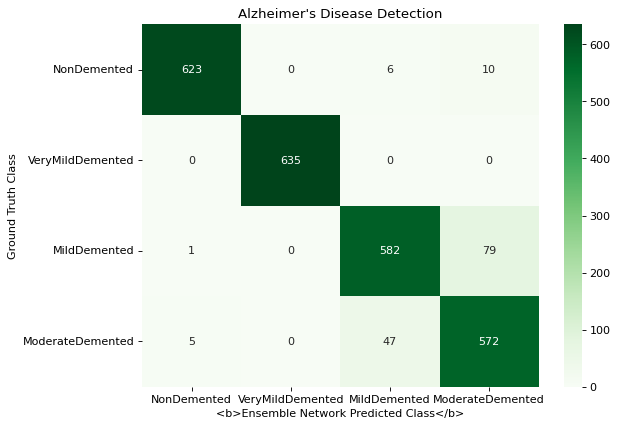

In [29]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

def roundoff(arr):
    arr[np.argwhere(arr!=arr.max())] = 0
    arr[np.argwhere(arr==arr.max())] = 1
    return arr

for labels in y_pred:
    labels = roundoff(labels)
    
print(classification_report(y_test, y_pred, target_names=CLASSES))
pred_ls = np.argmax(y_pred, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap="Greens", annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title("Alzheimer's Disease Detection")
plt.xlabel("Ensemble Network Predicted Class")
plt.ylabel("Ground Truth Class")
plt.show(ax)
# plt.savefig("ConfusionMatrix.png", dpi=400, bbox_inches="tight")

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets